# Практическая задача (36 баллов)

В этой задаче мы поработаем с разреженными системами, в том числе научимся быстро пересчитывать решение при изменениях ранга 1 в матрице левой части.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

### Расчёт напряжений в системе резисторов

При конструировании сверхбольших интегральных схем (СБИС, very large scale integration, VLSI) одной из базовых задачей является расчёт напряжений в электрических схемах довольно внушительных размеров. Мы рассмотрим модельный пример: сетку $m \times n$ с резисторами сопротивления $R$.

![Сетка из резисторов](resistors.svg)

Потенциалы в узлах сетки обозначим $\varphi_{ij}$, это и будут наши неизвестные. Давайте также считать, что к противоположным углам сетки ($(1,1)$ и $(m,n)$) приложена разность потенциалов $U$. Соответственно, в левый верхний угол втекает (неизвестный) ток $I$, и такой же ток вытекает из правого нижнего угла.

Для решения системы нам будет достаточно закона Ома и первого закона Кирхгофа. Именно, для каждого резистора легко выразить текущий через него ток. Например, для горизонтального резистора между узлами $(i,j)$ и $(i,j+1)$ ток равен $I_{i,j} = (\varphi_{ij} - \varphi_{i,j+1})/R$. Далее применяем первый закон Кирхгофа для каждого узла $(i,j)$, то есть приравниваем сумму втекающих токов к сумме вытекающих. Для внутреннего узла получим такое равенство:
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0.\tag{1}
$$
На границе, например, верхней (то есть $i = 1$), будет отсутствовать член $\varphi_{i-1,j}-\varphi_{i, j}$, а в углу, например, $(1,n)$, будет дополнительно отсутствовать член $\varphi_{i,j}-\varphi_{i, j+1}$. В углах $(1,1)$ и $(m, n)$, однако, ситуация особая: в первом есть дополнительный втекающий неизвестный ток $I$, а во втором этот же ток вытекает.
В результате получим систему на $\varphi_{i,j}$ и $I$:
$$
\left[ \begin{array}{ccccc|c}
   &&   && &  R \\
   &&   && &  0 \\
   && A && &  \vdots  \\
   &&   && &  0 \\
   &&   && & -R \\
   \hline
1 & 0 & \dots &  0 & -1 & 0
\end{array}
\right]
\begin{bmatrix}
\varphi_{11} \\
\vdots       \\
\vdots       \\
\vdots       \\
\varphi_{mn}  \\
I
\end{bmatrix}
=
\begin{bmatrix}
0 \\
\vdots       \\
\vdots       \\
\vdots       \\
0  \\
U
\end{bmatrix}
$$
Последнее уравнение есть $\varphi_{11}-\varphi_{mn} = U$.

Разберёмся с видом матрицы $A$. Она имеет размеры $mn \times mn$ и индексируется двумя парами индексов $ij$ и $i'j'$. Перепишем уравнение (2) в виде 
$$
(\varphi_{i,j-1} - 2\varphi_{i,j} + \varphi_{i,j+1}) + (\varphi_{i-1,j} - 2\varphi_{i,j} + \varphi_{i+1,j}) = 0.\tag{2}
$$
Если переписать столбец $\varphi$ с элементами $\varphi_{ij}$ в матрицу $\Phi\in\mathbb{R}^{m \times n}$ естественным образом (то есть так, чтобы $\mathrm{vec}(\Phi) = \varphi$), то ясно, что первое слагаемое в (2) действует на столбцы матрицы $\Phi$, а второе &mdash; на строки. То есть $A \varphi  = \mathrm{vec}(\Phi A_n) + \mathrm{vec}(A_m \Phi)$, где $A_n \in \mathbb{R}^{n \times n}$ и $A_m \in \mathbb{R}^{m \times m}$ имеют вид
$$
\begin{bmatrix}
-1 & 1 & &  \\
1 & -2 & 1 & \\
  &   & \ddots &  \\
  &     &    1 & -1
 \end{bmatrix}.
$$
По уже известной нам формуле для $\mathrm{vec}(\cdot)$ получается, что $A = A_n \otimes I_m + I_n \otimes A_m$. Операция в правой части ещё называется *Кронекеровой суммой* матриц $A_n$ и $A_m$ и обозначается $A_n \oplus A_m$ (можете проверить, что такая "сумма" не имеет такого интуитивного свойство суммы, как коммутативность, т.е. в общем случае $A_m \oplus A_n \neq A_n \oplus A_m$).

**Обратите внимание**, что система получилась линейно зависимой: если сложить все строки, кроме последней, получится нулевая строка (физически это отвечает тому, что все потенциалы можно сдвинуть на одинаковую константу).
Поэтому мы удалим предпоследнюю строку (не потеряв никакой информации, ведь она равнялась минус сумме остальных), а вместо неё добавим условие $\varphi_{mn} = 0$, таким образом фиксируя один из потенциалов, чтобы уничтожить неопределённость. Обозначим получившуюся $(mn+1)\times(mn+1)$ матрицу $B$.

## 1. Разреженное LU-разложение (16 баллов)

a. (**9 баллов**) Сформируйте разреженную матрицу решаемой системы в CSC формате. Для получения матриц $A_m, A_n$ используйте `scipy.sparse.spdiags`, а для сбора $A$ по $A_m, A_n$ используйте `scipy.sparse.kron` матрицы $A$. Обратите внимание, что в этом задании нельзя собирать $A$ или $A_m, A_n$ с использование операций с плотными матрицами.

In [2]:
from scipy import sparse

def make_A(m, n):
    "Returns sparse mn x mn matrix A"
    diags = np.array([0, -1, 1])

    tmpn = np.full(n, -2)
    tmpn[0] = -1
    tmpn[-1] = -1
    data = np.array([tmpn, np.full(n, 1), np.full(n, 1)])
    An = sparse.spdiags(data, diags, n, n)
    
    tmpm = np.full(m, -2)
    tmpm[0] = -1
    tmpm[-1] = -1
    data = np.array([tmpm, np.full(m, 1), np.full(m, 1)])
    Am = sparse.spdiags(data, diags, m, m)
    
    A = sparse.kron(An, sparse.eye(m)) + sparse.kron(sparse.eye(n), Am).tocsc()
    return A
    
def make_mat(m, n, R):
    "Returns sparse (mn + 1) x (mn + 1) matrix of the system in CSC format"
    A = make_A(m, n)
    A[-1] = 0 # как np.full(_, 0)
    A[-1, -1] = 1
    b = np.zeros(m * n)
    b[0] = R
    # b[-1] = -R
    b.resize(1, m * n)
    A = sparse.hstack((A, b.T))

    r = np.zeros(m * n + 1)
    r[0] = 1
    r[-2] = -1
    A = sparse.vstack((A, r)).tocsc()
    return A.tocsc()
    

In [3]:
A = make_mat(3, 3, 12)
print(A.toarray())

[[-2.  1.  0.  1.  0.  0.  0.  0.  0. 12.]
 [ 1. -3.  1.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0. -3.  1.  0.  1.  0.  0.  0.]
 [ 0.  1.  0.  1. -4.  1.  0.  1.  0.  0.]
 [ 0.  0.  1.  0.  1. -3.  0.  0.  1.  0.]
 [ 0.  0.  0.  1.  0.  0. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  1. -3.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0. -1.  0.]]


C:\Users\Oleg\Anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


b. (**7 баллов**) Заполните класс `Solver`, который при инициализации выполнит разреженное LU-разложение с помощью библиотеки `scipy.sparse.linalg` и функции `scipy.sparse.linalg.splu`, а затем будет уметь решать систему для заданной правой части.

In [4]:
import scipy.sparse.linalg

class Solver:
    def __init__(self, m, n, R):
        self.LU = scipy.sparse.linalg.splu(make_mat(m, n, R))
        self.shape = m * n + 1
    
    def solve(self, right):
        "Solves the system for given right part"
        return self.LU.solve(right)

    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        b = np.zeros(self.shape)
        b[-1] = U
        return self.solve(b)

Решим систему и визуализируем полученное решение, чтобы понять, как текут токи.

In [5]:
def visualize(m, n, R, solution, resistance_coeffs={}):
    plt.axis('off')
    max_current = 0
    lines = []
    for i in range(m):
        for j in range(n - 1):
            resistance = R * resistance_coeffs.get((i, j), 1)
            current = (solution[j * m + i] - solution[(j + 1) * m + i]) / resistance
            dx = 0.2 if current > 0 else -0.2
            plt.arrow(j+0.5, -i, dx, 0, shape='full', lw=2, length_includes_head=True, head_width=.10, color='blue')
            max_current = max(max_current, current)
            lines += plt.plot([j, j + 1], [-i, -i], color='blue', lw=abs(current))
    for i in range(m - 1):
        for j in range(n):
            current = (solution[j * m + i] - solution[j * m + i + 1]) / R
            dy = -0.1 if current > 0 else 0.1
            plt.arrow(j, -i - 0.5, 0, dy, shape='full', lw=2, length_includes_head=True, head_width=.08, color='blue')
            max_current = max(max_current, current)
            lines += plt.plot([j, j], [-i, -i - 1], color='blue', lw=abs(current))
    for l in lines:
        l.set_linewidth(l.get_linewidth() * 4. / max_current)

C:\Users\Oleg\Anaconda3\lib\site-packages\scipy\sparse\_index.py:126: SparseEfficiencyWarning: Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.
  self._set_arrayXarray(i, j, x)


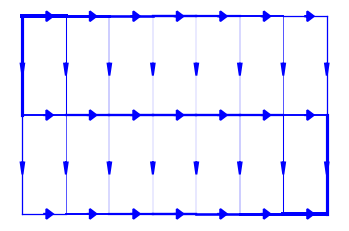

In [6]:
m, n, R = 3, 8, 1.
solver = Solver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))

Проверьте, что ваш солвер работает для больших систем.

In [7]:
m, n, R = 500, 500, 1.
solver = Solver(m, n, R)
_ = solver.solve_voltage(220.)

## 2. Обновления ранга 1 (20 баллов)

Представим теперь, что в процессе работы резисторы в нашей системе могут менять своё сопротивление, например, при перегреве проводник может потерять проводимость ($R_{i,j} = \infty$) или, напротив, может произойти короткое замыкание ($R_{i,j} = 0$). При таких локальных изменениях нет нужды строить и решать заново всю нашу линейную систему.

a. (**8 баллов**) Будем считать для простоты, что
  1. сопротивление меняется только в горизонтальных резисторах, не инцидентных узлам $(1,1)$ и $(m, n)$;
  2. в каждом проводе сопротивление может измениться только один раз.

Пусть сопротивление между узлами $(i,j)$ и $(i,j+1)$ изменилось с $R$ на $R'$. Пользуясь формулой (1), выпишите новую матрицу $B'$ в виде $B' = B + uv^\top$.


(можно написать решение в строчке ниже или на листке в теоретической части)

**YOUR WORDS GO HERE OR THERE**\
Формула (1):\
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0\tag{1}
$$

Нам нужно именно преобразование для *конкретных* индексов. Поэтому следует рассматривать то, как ведет себя матрица $B$ при умножении.\
А $B$ при умножении дает нам формулу 3 для узла $(i, j)$. Если же в одном месте изменить напряжение, то у нас поменяются 2 формулы - для $(i,j)$-го и $(i,j+1)$-го узлов, что соответствует двум строкам матрицы.\
Для горизонтального резистора между узлами $(i,j)$ и $(i,j+1)$ ток равен $I_{i,j} = \frac{\varphi_{ij} - \varphi_{i,j+1}}{R}$. Тогда при замене $R$ на $R'$ $I_{i,j} = \frac{\varphi_{ij}' - \varphi_{i,j+1}'}{R'}$. Так как меняется лишь сопротивление, то поменяются и значения потенциалов (ток течет по пути наименьшего сопротивления), однако в силу того, что наши $\varphi_{ij}$ являются неизвестными переменными, то я оставлю те же обозначения для потенциалов. Тогда получим формулу следующего вида:\
$$
\frac{\varphi_{i,j-1} - \varphi_{i,j}}{R} + \frac{\varphi_{i-1,j} - \varphi_{i,j}}{R} - \frac{\varphi_{i,j} - \varphi_{i,j+1}}{R'} - \frac{\varphi_{i,j} - \varphi_{i+1,j}}{R} = 0 \Longrightarrow
(\varphi_{i,j-1} - \varphi_{i,j}) + (\varphi_{i-1,j} - \varphi_{i,j}) - (\varphi_{i,j} - \varphi_{i,j+1})\frac{R}{R'} - (\varphi_{i,j} - \varphi_{i+1,j}) = 0
$$
Из полученной формулы вычтем формулу $(2)$:\
$$
- (\varphi_{i,j} - \varphi_{i,j+1})\frac{R}{R'} + \varphi_{i,j} - \varphi_{i,j+1} 
$$

Получим:
$$
-(\varphi_{i,j} - \varphi_{i,j+1}) \frac{R - R'}{R'} \tag{3}
$$
Именно так и изменится формула при изменении напряжения, т.е. к строке $(2)$ нужно добавить $(3)$. Иными словами, в строке матрицы $A$, соответствующей узлу $(i, j)$ из элемента, отвечающего за коэффициент перед $\phi_{i, j}$ нужно вычесть $\frac{R - R'}{R'}$, а к элементу, отвечающему за коэффициент перед $\phi_{i, j+1}$ - прибавить  $\frac{R - R'}{R'}$.

Распишем формулу $(1)$ теперь уже для узла $(i, j+1)$:
$$
\frac{\varphi_{i,j} - \varphi_{i,j+1}}{R'} + \frac{\varphi_{i-1,j+1} - \varphi_{i,j+1}}{R} - \frac{\varphi_{i,j+1} - \varphi_{i,j+2}}{R} - \frac{\varphi_{i,j+1} - \varphi_{i+1,j+1}}{R} = 0 \Longrightarrow
(\varphi_{i,j} - \varphi_{i,j+1})\frac{R}{R'} + (\varphi_{i-1,j+1} - \varphi_{i,j+1}) - (\varphi_{i,j+1} - \varphi_{i,j+2}) - (\varphi_{i,j+1} - \varphi_{i+1,j+1}) = 0
$$
И вычтем отсюда $(2)$:
$$
(\varphi_{i,j} - \varphi_{i,j+1})\frac{R}{R'} + (\varphi_{i-1,j+1} - \varphi_{i,j+1}) - (\varphi_{i,j+1} - \varphi_{i,j+2}) - (\varphi_{i,j+1} - \varphi_{i+1,j+1}) - (\varphi_{i,j} - 2\varphi_{i,j+1} + \varphi_{i,j+2}) - (\varphi_{i-1,j+1} - 2\varphi_{i,j+1} + \varphi_{i+1,j+1}) =
$$
$$
(\varphi_{i,j} - \varphi_{i,j+1})\frac{R}{R'} -\varphi_{i,j} + \varphi_{i,j+1} = 
$$
$$
(\varphi_{i,j} - \varphi_{i,j+1})\frac{R - R'}{R'} \tag{4}
$$
Получили то же самое. Аналогично, в строке матрицы $A$, соответствующей узлу $(i, j + 1)$ к элементу, отвечающим за коэффициент перед $\phi_{i, j}$ нужно прибавить $\frac{R - R'}{R'}$, а из элемента, отвечающего за коэффициент перед $\phi_{i, j+1}$ - вычесть $\frac{R - R'}{R'}$.

Пусть теперь $\Phi$ - матрица потенциалов, тогда $\mathrm{vec}(\Phi) = [\varphi_{11}, \varphi_{21}, \ldots, \varphi_{12}, \varphi_{22}, \ldots, \varphi_{mn}]$. Для $\varphi_{i,j+1}$ - $mj + (i - 1)$. Соответствующие элементы в этих строках будут стоять на пересечении столбцов с такими же индексами.\
Таким образом, нам нужно сделать следующее (нумерация подразумевается с нуля):
$$
B[mj + i][mj + i] -= \beta,$$ $$B[mj + i][m(j + 1) + i] += \beta,$$ $$B[m(j + 1) + i][mj + i] += \beta,$$  $$B[m(j + 1) + i][m(j + 1) + i] -= \beta;$$ $$\beta = \frac{R - R'}{R'}$$

Теперь разберемся с векторами $u, v$. Достаточно просто расписать и понять, что на $(mj + i)$-ом месте в векторе $v$ должно стоять $-beta$ и 1 на том же месте в $u$. Напротив, на месте $(m(j + 1) + i)$ в $v$ будет $\beta$ и также -1 в $u$.

Проверим наглядно:

In [8]:
m, n = 2, 3
u = np.full(m * n + 1, 0)
v = np.full(m * n + 1, 0)
i, j = 1, 2
i -= 1
j -= 1
u[m * j + i], u[m * (j + 1) + i] = 1, -1
v[m * j + i], v[m * (j + 1) + i] = -8, 8
u.resize((m * n + 1, 1))
v.resize((m * n + 1, 1))
print(u @ v.T)

[[ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0 -8  0  8  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  8  0 -8  0  0]
 [ 0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0]]


Далее воспользуемся формулой Шермана-Моррисона для обращения матрицы $B + uv^\top$:
$$
(B + uv^\top)^{-1} = B^{-1} - \frac{B^{-1}uv^\top B^{-1}}{1 + v^\top B^{-1}u}.
$$

b. (**12 баллов**) Напишите класс `UpdatableSolver`, использующий `Solver`, но вдобавок умеющий умножать сопротивление в заданном горизонтальном резисторе на заданное число.

Пусть $B_k = B_{k-1} + u_k v_k^T$, где $B_k$ - $B$ после $k$-го изменения. Тогда для $B_k$
$$
x = (B_{k-1} + u_k v_k^T)b = B_{k-1}^{-1}b - \frac{B^{-1}_{k-1} u_k v_k^\top B^{-1}_{k-1}b}{1 + v_k^\top B^{-1}_{k-1}u_k}
$$
Таким образом, для $k$-го изменения нужно решить $B_{k-1}^{-1}b$ и $B^{-1}_{k-1} u_k$.\
Возьмем, например, $k = 3$:
$$
x = B^{-1}_{3}b = (B_{2} + u_3 v_3^T)^{-1} b = B_{2}^{-1}b - \frac{B^{-1}_{2} u_3 v_3^\top B^{-1}_{2}b}{1 + v_3^\top B^{-1}_{2}u_3}
$$
На уровне $k = 2$ нужно решить:
$$
B_{2}^{-1}b = (B_{1} + u_2 v_2^T)^{-1}b,\  B^{-1}_{2} u_3 = (B_{1} + u_2 v_2^T)^{-1} u_3
$$

$$
B_{2}^{-1}b = B_{1}^{-1}b - \frac{B^{-1}_{1} u_2 v_2^\top B^{-1}_{1}b}{1 + v_2^\top B^{-1}_{1}u_2}
$$
$$
B_{2}^{-1}u_3 = B_{1}^{-1}u_3 - \frac{B^{-1}_{1} u_2 v_2^\top B^{-1}_{1}u_3}{1 + v_2^\top B^{-1}_{1}u_2}
$$
Далее - на уровень $k = 1$, решаем следующее:
$$От\ B_{2}^{-1}b - B_{1}^{-1}b\ и\ B^{-1}_{1} u_2,$$ $$От\ B_{2}^{-1}u_3 - B_{1}^{-1}u_3\ и\ B^{-1}_{1} u_2$$
Расписав все это по той же формуле, на уровне $k = 0$ получим:
$$От\ B_{1}^{-1}b - B^{-1}b\ и\ B^{-1}u_1,$$ $$От\ B^{-1}_{1}u_2 - B^{-1}u_2\ и\ B^{-1}u_1,$$ 
$$От\ B_{1}^{-1}u_3 - B^{-1}u_3\ и\ B^{-1}u_1,$$ $$От\ B^{-1}_{1}u_2 - B^{-1}u_2\ и\ B^{-1}u_1$$

Видно, что в конце мы получим $B^{-1}b,\ B^{-1}u_k,\ B^{-1}u_{k - 1}, \ldots,\  B^{-1}u_1$. Тогда имеет смысл хранить вычисленные такого рода значения, а затем уже из них собирать необходимые для решения. Сделаем просто циклом. Картинка (схема) прилагается:
![Заметка](photo_2021-05-16_21-24-57.jpg)

В нашем теоретическом решении $\beta = \frac{R - R'}{R'}$. Пусть $\alpha R = R' \Longrightarrow \beta = \frac{(1 - \alpha) R}{\alpha R} = \frac{(1 - \alpha)}{\alpha}$

In [17]:
from  scipy.sparse import csr_matrix

def Sh_Morr_sol(Bb, Bu, v):
    x = Bb - (csr_matrix(Bu) @ v.T @ Bb) / (1 + v.T @ Bu) 
    return x

class UpdatableSolver:
    def __init__(self, m, n, R):
        self.LU = scipy.sparse.linalg.splu(make_mat(m, n, R))
        self.shape = m * n + 1
        self.m = m
        self.n = n
        self.count = 0
        self.v = []
        self.Bu = []
        self.answer = []
        
    def build_Bk(self):       
        arr = self.Bu
        Bkb = self.answer
        for i in range(0, self.count):
            Bkb = Sh_Morr_sol(Bkb, arr[0], self.v[i])
            new_arr = []
            for j in range(1, self.count - i):
                new_arr.append( Sh_Morr_sol(arr[j], arr[0], self.v[i]) )
            arr = new_arr

        return Bkb 
                     

    def solve(self, b):
        "Solves the system for given right part"
        self.answer = self.LU.solve(b).reshape((self.shape, 1))
        if (self.count == 0):
            return self.answer       
        
        return self.build_Bk()
    
    def update(self, i, j, coeff):
        """
            Updates the system so that the resistance between (i,j) and (i,j+1)
            is mutiplied by coeff.
        """
        self.count += 1
        beta = (1 - coeff) / coeff
        m = self.m
        n = self.n
        
        u = np.zeros(self.shape)
        v = scipy.sparse.dok_matrix( (self.shape, 1) )
        u[m * j + i], u[m * (j + 1) + i] = 1, -1
        v[m * j + i], v[m * (j + 1) + i] = -beta, beta
        self.Bu.append( self.LU.solve(u.reshape((self.shape, 1))) )
        self.v.append(v.tocsc())
    
    def solve_voltage(self, U):
        "Solves the updated system for given voltage"
        b = np.zeros(self.shape)
        b[-1] = U
        return self.solve(b).reshape((self.shape, 1)) 

Поэкспериментируем с изменением проводимости отдельных участков. Попробуем сильно увеличить сопротивление сначала одного, затем другого резистора в одном вертикальном ряду. 

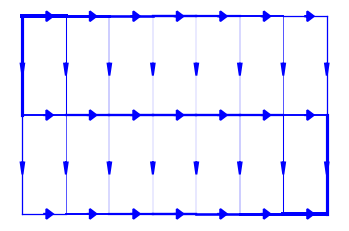

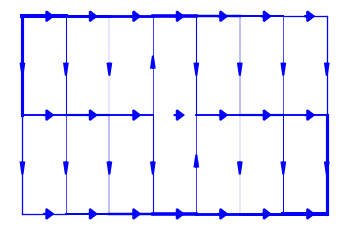

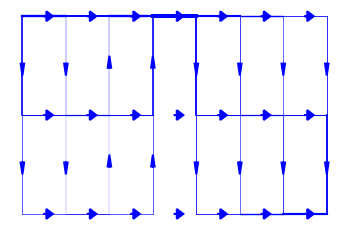

In [18]:
m, n, R = 3, 8, 1.
solver = UpdatableSolver(m, n, R)
visualize(m, n, R, solver.solve_voltage(220.))
plt.figure()
coeff = 1000
resistance_coeffs = {(1,3): coeff}
solver.update(1, 3, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)
plt.figure()
resistance_coeffs[(2,3)] = coeff
solver.update(2, 3, coeff)
visualize(m, n, R, solver.solve_voltage(220.), resistance_coeffs=resistance_coeffs)

Также проверим, что новый солвер работает для больших систем.

In [19]:
m, n, R = 300, 300, 1.
solver = UpdatableSolver(m, n, R)
solver.solve_voltage(220.)
solver.update(10, 20, 100.)
solver.update(20, 30, 100.)
solver.update(30, 40, 100.)
_ = solver.solve_voltage(220.)